A working example of the ZCU216 qick-qcodes test suite. Currently, as is seen in this demo, multidimensional sweeping is possible for pulse frequency, phase, gain, and lenght. Only the pulse frequency sweeping is done on software, so that might lead to noticeable overhead when sweeping frequency. Other sweep variables are looped over in hardware. No other protocols, such as those specifically designed for characterizing qubits are implemented yet. 

In [1]:
from metainstrument import ZCU216Station, ZCU216MetaInstrument
import qcodes as qc
from qcodes.instrument import Instrument, ManualParameter
from qcodes.station import Station
from qcodes.utils.validators import Numbers, MultiType, Ints
from qick import *
from protocols import Protocol, NDSweepProtocol
import numpy as np

import matplotlib.pyplot as plt


In [2]:
#Initializing the station and the database
qc.initialise_or_create_database_at("./zcu_test_data.db")

station = ZCU216Station()
station.add_component(ZCU216MetaInstrument(name="zcu"))

'zcu'

In [3]:
#A simple frequency sweep, demonstrating the difference between the nyquist zones

station.zcu.gain(20000)

#Setting the nyquist zone to 1
station.zcu.nqz(1)
print(station.zcu.print_readable_snapshot())


#Running an iq_measurement, by using the protocol NDSweepProtocol, and giving the sweep parameters within a dictionary
run_id_nqz1 = station.measure_iq(params_and_values = {station.zcu.freq: [100,8000,2000]}, protocol = NDSweepProtocol())

#Again for the second nyquist zone
station.zcu.nqz(2)

run_id_nqz2 = station.measure_iq(params_and_values = {station.zcu.freq: [100,8000,2000]}, protocol = NDSweepProtocol())


zcu:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': None, 'model': 'zcu', 'serial': None, 'firmware'...
adc_trig_offset :	0.1 (us)
freq            :	None (MHz)
gain            :	20000 (DAC units)
length          :	None (Clock cycles)
nqz             :	1 
phase           :	None (deg)
qubit_ch        :	6 
relax_delay     :	0.1 (us)
reps            :	100 
res_ch          :	0 
soft_avgs       :	1 
None
Starting experimental run with id: 346. 
Starting experimental run with id: 347. 


/usr/local/share/pynq-venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Text(0, 0.5, 'Amplitude')

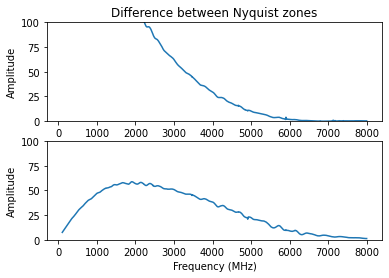

In [4]:
#Plotting the results
ds1 = qc.load_by_id(run_id_nqz1).to_xarray_dataset()
ds2 = qc.load_by_id(run_id_nqz2).to_xarray_dataset()


plt.subplot(2, 1, 1)
plt.plot(ds1["freq"], abs(ds1["avg_q"] + 1j*ds1["avg_i"]))
plt.ylim(0,100)
plt.title('Difference between Nyquist zones')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(ds2["freq"], abs(ds2["avg_q"] + 1j*ds2["avg_i"]))
plt.ylim(0,100)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')

In [6]:
#Since we have implemented multidimensional sweeping, we may do a sweep of phase over gain 
phase_over_gain_id = station.measure_iq(params_and_values = {
    station.zcu.phase: [0,360,200],
    station.zcu.gain: [1000, 10000, 200]},
    protocol = NDSweepProtocol())

ds_gain_phase = qc.load_by_id(phase_over_gain_id).to_xarray_dataset()


Starting experimental run with id: 349. 


Text(0, 0.5, 'Phase')

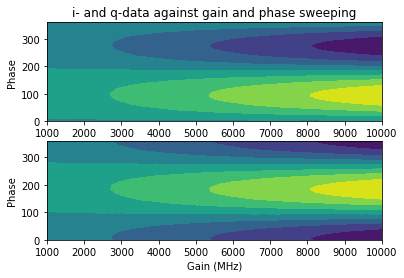

In [7]:
#And then separately plot the i and q data against gain and phase

plt.subplot(2, 1, 1)
plt.contourf(ds_gain_phase["phase"], ds_gain_phase["gain"], ds_gain_phase["avg_q"])
plt.title('i- and q-data against gain and phase sweeping')
plt.xlabel('Gain (MHz)')
plt.ylabel('Phase')


plt.subplot(2, 1, 2)
plt.contourf(ds_gain_phase["phase"], ds_gain_phase["gain"], ds_gain_phase["avg_i"])
plt.xlabel('Gain (MHz)')
plt.ylabel('Phase')
#plt.contourf(ds["phase"], ds["gain"], abs(ds["avg_q"]+1j*ds["avg_i"]))

Text(0, 0.5, 'Phase')

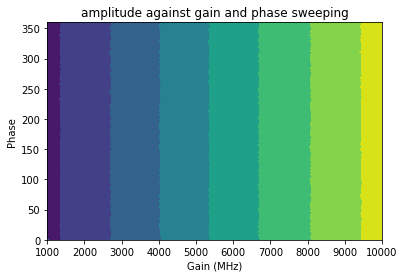

In [8]:
#Finally, the amplitude from the previous sweep
plt.contourf(ds_gain_phase["phase"], ds_gain_phase["gain"], abs(ds_gain_phase["avg_q"]+1j*ds_gain_phase["avg_i"]))
plt.title('amplitude against gain and phase sweeping')
plt.xlabel('Gain (MHz)')
plt.ylabel('Phase')

In [9]:
#Frequency sweep using a bandpass filter 4.9-6.2 GHz

station.zcu.gain(10000)

#Setting the nyquist zone to 2
station.zcu.nqz(2)
bandpass_run_id = station.measure_iq(params_and_values = {station.zcu.freq: [4500,6500,1000]}, protocol = NDSweepProtocol())

Starting experimental run with id: 350. 


In [10]:
no_bandpass_run_id = station.measure_iq(params_and_values = {station.zcu.freq: [4500,6500,1000]}, protocol = NDSweepProtocol())

Starting experimental run with id: 351. 


Text(0, 0.5, 'Amplitude')

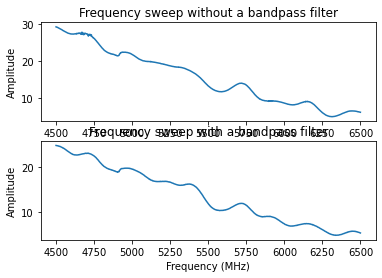

In [12]:
#Plotting the results
no_bp_ds = qc.load_by_id(no_bandpass_run_id).to_xarray_dataset()
bp_ds = qc.load_by_id(bandpass_run_id).to_xarray_dataset()

plt.subplot(2, 1, 1)
plt.plot(no_bp_ds["freq"], abs(no_bp_ds["avg_q"] + 1j*no_bp_ds["avg_i"]))
plt.title('Frequency sweep without a bandpass filter')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(bp_ds["freq"], abs(bp_ds["avg_q"] + 1j*bp_ds["avg_i"]))
plt.title('Frequency sweep with a bandpass filter')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')